In [1]:
import numpy as np
import matplotlib.pyplot as plt

### artificial dataset generation

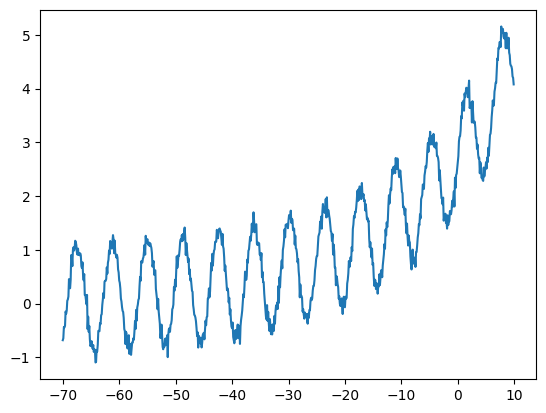

In [2]:
#X_t = np.arange(-170,170,0.1)
X_t = np.arange(-70,10,0.1)
#X_t = np.arange(-10,10,0.1)
X_t = X_t.reshape(len(X_t),1)
Y_t = np.sin(X_t) + 0.1*np.random.randn(len(X_t),1) + np.exp((X_t + 20)*0.05)

#Y_t = np.multiply(Y_t, 10*np.sin(0.1*X_t))

plt.plot(X_t, Y_t)
plt.show()


### create LSTM network and the LSTM cell

In [22]:
class SigmoidAct:
    def forward(self,input):
        self.input = input
        self.output = np.clip(1/(1+np.exp(-self.input)),1e-7,1-1e-7) 

    def backward(self,dvalues):
        deriv = np.multiply(self.input,(1-self.input))
        self.dinputs = np.multiply(deriv,dvalues)

class TanhAct:
    def forward(self,input):
        self.input = input
        self.output = np.tanh(self.input)

    def backward(self,dvalues):
        deriv = 1-self.output**2
        self.dinputs= np.multiply(deriv,dvalues)
    
class LSTM:
    def __init__(self,hidden_size:int=64):
        self.n_neurons = hidden_size
        # INITILAZING LEARNABLE WEIGHT MATRICES
        self.Uf = 0.1*np.random.randn(self.n_neurons,1)
        self.Wf = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bf = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Ui = 0.1*np.random.randn(self.n_neurons,1)
        self.Wi = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bi = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Uo = 0.1*np.random.randn(self.n_neurons,1)
        self.Wo = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bo = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Uc_tilde = 0.1*np.random.randn(self.n_neurons,1)
        self.Wc_tilde = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bc_tilde = 0.1*np.random.randn(self.n_neurons,1)
        
    def forward(self,X_t:np.ndarray):
        self.X_t = X_t
        self.n = self.X_t.shape[0]
        
        self.H = [np.zeros((self.n_neurons,1)) for t in range(self.n+1)]
        self.C = [np.zeros((self.n_neurons,1)) for t in range(self.n+1)]
        self.C_tilde = [np.zeros((self.n_neurons,1)) for t in range(self.n)]

        self.F = [np.zeros_like(self.bf) for t in range(self.n)]
        self.I = [np.zeros_like(self.bi) for t in range(self.n)]
        self.O = [np.zeros_like(self.bo) for t in range(self.n)]

        # now initialize the weight gradients
        self.dUf = 0.1*np.random.randn(self.n_neurons,1)
        self.dWf = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.dbf = 0.1*np.random.randn(self.n_neurons,1)
        
        self.dUi = 0.1*np.random.randn(self.n_neurons,1)
        self.dWi = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.dbi = 0.1*np.random.randn(self.n_neurons,1)
        
        self.dUo = 0.1*np.random.randn(self.n_neurons,1)
        self.dWo = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.dbo = 0.1*np.random.randn(self.n_neurons,1)
        
        self.dUc_tilde = 0.1*np.random.randn(self.n_neurons,1)
        self.dWc_tilde = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.dbc_tilde = 0.1*np.random.randn(self.n_neurons,1)
         
        self.SigmF = [SigmoidAct() for t in range(self.n)]
        self.SigmI = [SigmoidAct() for t in range(self.n)]
        self.SigmO = [SigmoidAct() for t in range(self.n)]
        
        self.Tanh_ctilde = [TanhAct() for t in range(self.n)]
        self.Tanh_c = [TanhAct() for t in range(self.n)]

        # init the first values for ht and ct
        ht = self.H[0]
        ct = self.C[0]

        # then the LSTM cell will take those and compute resultant states, and returns back.
        # it will update all of the states: self.H,self.C,self.O,self.I,self.C_tilde
        # for X_t using ht, ct at first then iterating thru all the time steps
        # and applying corresponding activation functions.
        self.LSTMCell(ht,ct) # actual forward pass thru the cell, for all time steps

    def LSTMCell(self,ht,ct):
        for t, xt in enumerate(self.X_t):
            xt = xt.reshape(1,1)

            # forget gate
            outf = np.dot(self.Uf,xt)+np.dot(self.Wf,ht)+self.bf
            self.SigmF[t].forward(outf)
            # input gate
            outi = np.dot(self.Ui,xt)+np.dot(self.Wi,ht)+self.bi
            self.SigmI[t].forward(outi)
            # output gate
            outo = np.dot(self.Uo,xt)+np.dot(self.Wo,ht)+self.bo
            self.SigmO[t].forward(outo)

            # c_tilde
            outc_tilde = np.dot(self.Uc_tilde,xt)+np.dot(self.Wc_tilde,ht)+self.bc_tilde
            self.Tanh_ctilde[t].forward(outc_tilde)


            ct = np.multiply(self.SigmF[t].output,self.C[t]) +\
                  np.multiply(self.SigmI[t].output,self.Tanh_ctilde[t].output) 

            self.Tanh_c[t].forward(ct)
            ht = np.multiply(self.Tanh_c[t].output,self.SigmO[t].output)

            self.H[t+1] = ht
            self.C[t+1] = ct 
            self.C_tilde[t] = self.Tanh_ctilde[t].output
        


In [23]:
lstm_model = LSTM()
lstm_model.forward(X_t)

In [29]:
np.array(lstm_model.H).shape, np.array(lstm_model.C).shape

((201, 64, 1), (201, 64, 1))

In [33]:
np.array(lstm_model.C_tilde).shape, lstm_model.n

((200, 64, 1), 200)

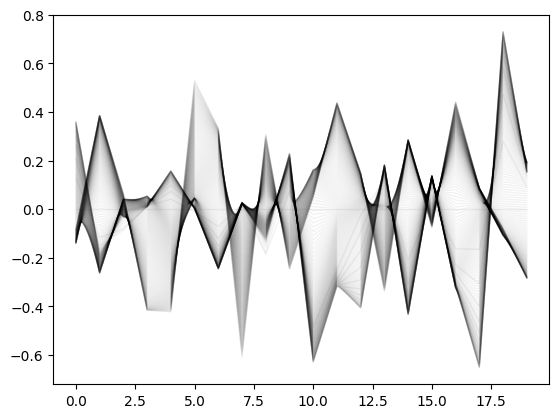

In [35]:
# plotting cell states
for h in lstm_model.H:
    plt.plot(np.arange(20),h[0:20], "k-",linewidth=1,alpha=0.05)

### NOW IMPLEMENT BPTT

In [38]:
class SigmoidAct:
    def forward(self,input):
        sigm = np.clip(1/(1 + np.exp(-input)), 1e-7, 1 - 1e-7)
        self.input = input
        self.output = sigm

    def backward(self,dvalues):
        deriv = np.multiply(self.output,(1-self.output))
        self.dinputs = np.multiply(deriv,dvalues)

class TanhAct:
    def forward(self,input):
        self.input = input
        self.output = np.tanh(self.input)

    def backward(self,dvalues):
        deriv = 1-self.output**2
        self.dinputs= np.multiply(deriv,dvalues)
    
class LSTM:
    def __init__(self,hidden_size:int=64):
        self.n_neurons = hidden_size
        # INITILAZING LEARNABLE WEIGHT MATRICES
        self.Uf = 0.1*np.random.randn(self.n_neurons,1)
        self.Wf = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bf = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Ui = 0.1*np.random.randn(self.n_neurons,1)
        self.Wi = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bi = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Uo = 0.1*np.random.randn(self.n_neurons,1)
        self.Wo = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bo = 0.1*np.random.randn(self.n_neurons,1)
        
        self.Uc_tilde = 0.1*np.random.randn(self.n_neurons,1)
        self.Wc_tilde = 0.1*np.random.randn(self.n_neurons,self.n_neurons)
        self.bc_tilde = 0.1*np.random.randn(self.n_neurons,1)
        
    def forward(self,X_t:np.ndarray):
        self.X_t = X_t
        self.n = self.X_t.shape[0]
        
        self.H = [np.zeros((self.n_neurons,1)) for t in range(self.n+1)]
        self.C = [np.zeros((self.n_neurons,1)) for t in range(self.n+1)]
        self.C_tilde = [np.zeros((self.n_neurons,1)) for t in range(self.n)]

        self.F = [np.zeros_like(self.bf) for t in range(self.n)]
        self.I = [np.zeros_like(self.bi) for t in range(self.n)]
        self.O = [np.zeros_like(self.bo) for t in range(self.n)]

        # now initialize the weight gradients
        self.dUf = np.zeros_like(self.Uf)
        self.dWf = np.zeros_like(self.Wf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dUi = np.zeros_like(self.Ui)
        self.dWi = np.zeros_like(self.Wi)
        self.dbi = np.zeros_like(self.bi)
        
        
        self.dUo = np.zeros_like(self.Uo)
        self.dWo = np.zeros_like(self.Wo)
        self.dbo = np.zeros_like(self.bo)
        
        
        self.dUc_tilde = np.zeros_like(self.Uc_tilde)
        self.dWc_tilde = np.zeros_like(self.Wc_tilde)
        self.dbc_tilde = np.zeros_like(self.bc_tilde)
        
         
        self.SigmF = [SigmoidAct() for t in range(self.n)]
        self.SigmI = [SigmoidAct() for t in range(self.n)]
        self.SigmO = [SigmoidAct() for t in range(self.n)]
        
        self.Tanh_ctilde = [TanhAct() for t in range(self.n)]
        self.Tanh_c = [TanhAct() for t in range(self.n)]

        # init the first values for ht and ct
        ht = self.H[0]
        ct = self.C[0]

        # then the LSTM cell will take those and compute resultant states, and returns them back.
        # it will update all of the states: self.H,self.C,self.O,self.I,self.C_tilde
        # for X_t using ht, ct at first then iterating thru all the time steps
        # and applying corresponding activation functions.
        self.LSTMCell(ht,ct) # actual forward pass thru the cell, for all time steps

    def LSTMCell(self,ht,ct):
        for t, xt in enumerate(self.X_t):
            xt = xt.reshape(1,1)

            # forget gate
            outf = np.dot(self.Uf,xt)+np.dot(self.Wf,ht)+self.bf
            self.SigmF[t].forward(outf)
            # input gate
            outi = np.dot(self.Ui,xt)+np.dot(self.Wi,ht)+self.bi
            self.SigmI[t].forward(outi)
            # output gate
            outo = np.dot(self.Uo,xt)+np.dot(self.Wo,ht)+self.bo
            self.SigmO[t].forward(outo)

            # c_tilde
            outc_tilde = np.dot(self.Uc_tilde,xt)+np.dot(self.Wc_tilde,ht)+self.bc_tilde
            self.Tanh_ctilde[t].forward(outc_tilde)


            ct = np.multiply(self.SigmF[t].output,self.C[t]) +\
                  np.multiply(self.SigmI[t].output,self.Tanh_ctilde[t].output) 

            self.Tanh_c[t].forward(ct)
            ht = np.multiply(self.Tanh_c[t].output,self.SigmO[t].output)

            self.H[t+1] = ht
            self.C[t+1] = ct 
            self.C_tilde[t] = self.Tanh_ctilde[t].output

            self.F[t] = self.SigmF[t].output
            self.I[t] = self.SigmI[t].output
            self.O[t] = self.SigmO[t].output

    def backward(self,dvalues):
        dht = dvalues[-1,:].reshape(self.n_neurons,1)
        for t in reversed(range(self.n)):
            xt= self.X_t[t].reshape(1,1)
            self.Tanh_c[t].backward(dht)
            dtanh_c = self.Tanh_c[t].dinputs
            dhtdtanh = np.multiply(self.O[t],dtanh_c)

            dctdft = np.multiply(dhtdtanh,self.C[t-1])
            dctdit = np.multiply(dhtdtanh,self.C_tilde[t])
            dctdct_tilde = np.multiply(dhtdtanh,self.I[t])

            self.Tanh_ctilde[t].backward(dctdct_tilde)
            dtanh_ctilde = self.Tanh_ctilde[t].dinputs

            self.SigmF[t].backward(dctdft)
            dsigmf = self.SigmF[t].dinputs

            self.SigmI[t].backward(dctdit)
            dsigmi = self.SigmI[t].dinputs

            self.SigmO[t].backward(np.multiply(dht,self.Tanh_c[t].output))
            dsigmo = self.SigmO[t].dinputs

            dsigmfdUf = np.dot(dsigmf,xt)
            dsigmfdWf = np.dot(dsigmf,self.H[t-1].T)#T:dim compatibility
            self.dUf += dsigmfdUf
            self.dWf += dsigmfdWf
            self.dbf += dsigmf

            dsigmidUi = np.dot(dsigmi,xt)
            dsigmidWi = np.dot(dsigmi,self.H[t-1].T)#T:dim compatibility
            self.dUi += dsigmidUi
            self.dWi += dsigmidWi
            self.dbi += dsigmi


            dsigmodUo = np.dot(dsigmo,xt)
            dsigmodWo = np.dot(dsigmo,self.H[t-1].T)#T:dim compatibility
            self.dUo += dsigmodUo
            self.dWo += dsigmodWo
            self.dbo += dsigmo


            dtanh_ctildedUctilde = np.dot(dtanh_ctilde,xt)
            dtanh_ctildedWctilde = np.dot(dtanh_ctilde,self.H[t-1].T)
            self.dUc_tilde += dtanh_ctildedUctilde
            self.dWc_tilde += dtanh_ctildedWctilde
            self.dbc_tilde += dtanh_ctilde

            # lastly, update the dht for the next time step
            dht = np.dot(self.Wf,dsigmf) + np.dot(self.Wi,dsigmi)+\
                    np.dot(self.Wo,dsigmo) + np.dot(self.Wc_tilde,dtanh_ctilde)+\
                    dvalues[t-1,:].reshape(self.n_neurons,1)
            












### now lets run our backprob. fully

In [39]:
class FC():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1*np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.inputs  = inputs
        self.output  = np.dot(self.inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T,dvalues)#dL=dy_hat-dy -> y=Wx+n -> dvalues*x 
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)# dL=dy_hat-dy -> y=Wx+n -> 0 + dvalues
        self.dinputs  = np.dot(dvalues, self.weights.T)#dL=dy_hat-dy -> y=Wx+n -> dvalues*W


n_neurons = 300
model = LSTM(hidden_size=n_neurons)
T = X_t.shape[0]
fc = FC(n_neurons,T)
out = FC(T,1)
learning_rate = 1e-5
epochs = 250
history = np.zeros((epochs))


for i in range(epochs):
    
    model.forward(X_t)
    H = np.array(model.H)
    H = H.reshape((H.shape[0],H.shape[1]))
    fc.forward(H[1:,:])
    out.forward(fc.output) 

    Y_hat = out.output
    dY = Y_hat-Y_t
    L = 0.5 * np.mean((dY ** 2)) # mse

    history[i] = L
    print(f"iter {i}: current loss: {L}")
    out.backward(dY)
    fc.backward(out.dinputs)
    model.backward(fc.dinputs)

    # update params
    fc.weights -= learning_rate*fc.dweights
    out.weights -= learning_rate*out.dweights
    fc.biases -= learning_rate*fc.dbiases
    out.biases -= learning_rate*out.dbiases

    model.Uf -= learning_rate*model.dUf
    model.Ui -= learning_rate*model.dUi
    model.Uo -= learning_rate*model.dUo
    model.Uc_tilde -= learning_rate*model.dUc_tilde
    
    model.Wf -= learning_rate*model.dWf
    model.Wi -= learning_rate*model.dWi
    model.Wo -= learning_rate*model.dWo
    model.Wc_tilde -= learning_rate*model.dWc_tilde

    model.bf -= learning_rate*model.dbf
    model.bi -= learning_rate*model.dbi
    model.bo -= learning_rate*model.dbo
    model.bc_tilde -= learning_rate*model.dbc_tilde

    
plt.plot(range(epochs),history)
plt.xlabel("epochs")
plt.ylabel("MSE")


iter 0: current loss: 2.2595367079399202
iter 1: current loss: 31.266790136377352
iter 2: current loss: 515.0225199885986
iter 3: current loss: 87.13627579898984
iter 4: current loss: 374.24114804995764
iter 5: current loss: 128.69966253763465
iter 6: current loss: 4.4897740532266965
iter 7: current loss: 1.2636966646400927
iter 8: current loss: 0.8031952897640884
iter 9: current loss: 0.6721283581205827
iter 10: current loss: 0.6039186187954935
iter 11: current loss: 0.5545419912079648
iter 12: current loss: 0.5145936957411259
iter 13: current loss: 0.4811784106419072
iter 14: current loss: 0.45288191591919547
iter 15: current loss: 0.42875875078171743
iter 16: current loss: 0.408088049961419
iter 17: current loss: 0.3902937741455412
iter 18: current loss: 0.37490748736278534
iter 19: current loss: 0.3615453921804721
iter 20: current loss: 0.3498916426408087
iter 21: current loss: 0.3396852717768728
iter 22: current loss: 0.33070970907843417
iter 23: current loss: 0.32278438491134326


KeyboardInterrupt: 

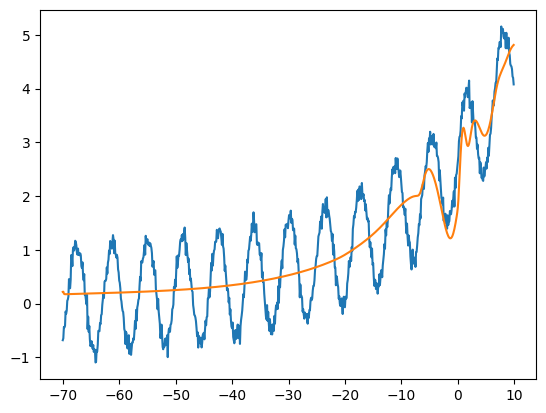

In [44]:
def test_model(model, fc, out, X_test):
    model.forward(X_test)
    
    H = np.array(model.H)
    if H.ndim > 2:
        H = H.reshape((H.shape[0], H.shape[1]))
    
    fc.forward(H[1:, :])
    out.forward(fc.output)
    Y_pred = out.output
    return Y_pred

# Example usage
X_t_test = X_t  # Example test data; replace with your actual test data
Y_test_pred = test_model(model, fc, out, X_t_test)

plt.plot(X_t_test,Y_t)
plt.plot(X_t_test,Y_test_pred)

### FIXME:
    - model not improving continually, most likely not transferring the weights to the next iter 
    - the iterative prediction bug
    - utilize Xavier initialization

### improve-me:
    - apply mini-batch gradient descent by random sampling